In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm

# ============================================================
# CONFIGURATION
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_GPUS = torch.cuda.device_count()

BATCH_SIZE = 4 * max(1, NUM_GPUS)
EPOCHS = 10
SEQ_LEN = 16
LR = 1e-4

NUM_WORKERS = 2
PIN_MEMORY = False

BASE_PATH = "/kaggle/input/ucf101-action-recognition"
TRAIN_DIR = os.path.join(BASE_PATH, "train")
VAL_DIR   = os.path.join(BASE_PATH, "val")

MODEL_PATH   = "action_model.pth"
CLASSES_PATH = "classes.txt"

print(f"🚀 Device: {DEVICE} | GPUs: {NUM_GPUS}")

# ============================================================
# FRAME EXTRACTION
# ============================================================
def extract_frames(video_path, seq_len):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total <= 0:
        cap.release()
        return []

    indices = set(np.linspace(0, total - 1, seq_len).astype(int))
    frames = []

    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if idx in indices:
            frame = cv2.resize(frame, (224, 224))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(np.ascontiguousarray(frame))

        idx += 1
        if len(frames) == seq_len:
            break

    cap.release()
    return frames

# ============================================================
# DATASET
# ============================================================
class ActionVideoDataset(Dataset):
    def __init__(self, root_dir, seq_len):
        self.samples = []
        self.seq_len = seq_len

        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for video in os.listdir(cls_path):
                self.samples.append(
                    (os.path.join(cls_path, video), self.class_to_idx[cls])
                )

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = extract_frames(video_path, self.seq_len)

        if len(frames) == 0:
            frames = [np.zeros((224, 224, 3), dtype=np.uint8)] * self.seq_len
        elif len(frames) < self.seq_len:
            frames += [frames[-1]] * (self.seq_len - len(frames))

        frames = torch.stack([self.transform(f) for f in frames]).contiguous()
        return frames, torch.tensor(label, dtype=torch.long)

# ============================================================
# MODEL
# ============================================================
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        resnet = models.resnet50(weights="IMAGENET1K_V1")
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])

        for p in self.cnn.parameters():
            p.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=2048,
            hidden_size=512,
            num_layers=1,
            batch_first=True
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(b * t, c, h, w)

        with torch.no_grad():
            features = self.cnn(x)

        features = features.squeeze(-1).squeeze(-1)
        features = features.view(b, t, -1)

        lstm_out, _ = self.lstm(features)
        return self.fc(lstm_out[:, -1])

# ============================================================
# TRAINING
# ============================================================
train_ds = ActionVideoDataset(TRAIN_DIR, SEQ_LEN)
val_ds   = ActionVideoDataset(VAL_DIR, SEQ_LEN)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

with open(CLASSES_PATH, "w") as f:
    for c in train_ds.classes:
        f.write(c + "\n")

model = CNN_LSTM(len(train_ds.classes))
if NUM_GPUS > 1:
    model = nn.DataParallel(model)

model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
print("\n--- Training Started ---")

for epoch in range(EPOCHS):
    model.train()
    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(videos), labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            preds = model(videos).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Validation Accuracy: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save(
            model.module.state_dict() if isinstance(model, nn.DataParallel)
            else model.state_dict(),
            MODEL_PATH
        )
        print("⭐ Best model saved")

print("\n--- Training Complete ---")

# ============================================================
# DEPLOYMENT-SAFE LOAD
# ============================================================
def load_trained_model(model_path, classes_path, device):
    with open(classes_path) as f:
        classes = [line.strip() for line in f]

    model = CNN_LSTM(len(classes))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model, classes

# ============================================================
# IMAGE ANNOTATION
# ============================================================
def annotate_and_save(image_path, model, class_names, output_path="annotated_result.jpg"):
    img = cv2.imread(image_path)
    if img is None:
        return "Image not found"

    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.ascontiguousarray(img)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    tensor = transform(img).unsqueeze(0).unsqueeze(0).contiguous().to(DEVICE)

    with torch.no_grad():
        pred_idx = model(tensor).argmax(1).item()

    label = class_names[pred_idx]

    original = cv2.imread(image_path)
    cv2.rectangle(original, (10, 10), (420, 60), (0, 0, 0), -1)
    cv2.putText(original, f"Action: {label}", (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imwrite(output_path, original)
    return label


🚀 Device: cuda | GPUs: 2
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s] 



--- Training Started ---


Epoch 1/10: 100%|██████████| 1257/1257 [07:36<00:00,  2.76it/s]


Validation Accuracy: 32.28%
⭐ Best model saved


Epoch 2/10: 100%|██████████| 1257/1257 [06:50<00:00,  3.06it/s]


Validation Accuracy: 49.07%
⭐ Best model saved


Epoch 3/10: 100%|██████████| 1257/1257 [06:52<00:00,  3.05it/s]


Validation Accuracy: 60.01%
⭐ Best model saved


Epoch 4/10: 100%|██████████| 1257/1257 [06:53<00:00,  3.04it/s]


Validation Accuracy: 64.08%
⭐ Best model saved


Epoch 5/10: 100%|██████████| 1257/1257 [06:57<00:00,  3.01it/s]


Validation Accuracy: 68.80%
⭐ Best model saved


Epoch 6/10: 100%|██████████| 1257/1257 [06:56<00:00,  3.01it/s]


Validation Accuracy: 70.17%
⭐ Best model saved


Epoch 7/10: 100%|██████████| 1257/1257 [06:59<00:00,  2.99it/s]


Validation Accuracy: 74.00%
⭐ Best model saved


Epoch 8/10: 100%|██████████| 1257/1257 [06:57<00:00,  3.01it/s]


Validation Accuracy: 73.46%


Epoch 9/10: 100%|██████████| 1257/1257 [06:55<00:00,  3.03it/s]


Validation Accuracy: 76.03%
⭐ Best model saved


Epoch 10/10: 100%|██████████| 1257/1257 [06:56<00:00,  3.02it/s]


Validation Accuracy: 77.76%
⭐ Best model saved

--- Training Complete ---


Loaded test set with 1723 samples

📊 TEST ACCURACY: 79.11%

📄 Classification Report (Precision / Recall / F1):

                    precision    recall  f1-score   support

    ApplyEyeMakeup     0.9286    0.6842    0.7879        19
     ApplyLipstick     0.7222    0.8667    0.7879        15
           Archery     0.8947    0.8947    0.8947        19
      BabyCrawling     0.7083    1.0000    0.8293        17
       BalanceBeam     0.8750    0.5000    0.6364        14
      BandMarching     0.9524    1.0000    0.9756        20
     BaseballPitch     0.6538    0.8947    0.7556        19
        Basketball     0.5714    0.4706    0.5161        34
    BasketballDunk     0.3846    0.2941    0.3333        17
        BenchPress     0.8000    1.0000    0.8889        20
            Biking     0.8500    1.0000    0.9189        17
         Billiards     1.0000    1.0000    1.0000        19
       BlowDryHair     1.0000    0.7647    0.8667        17
    BlowingCandles     0.9231    0.8571    0.88

<Figure size 1400x1200 with 0 Axes>

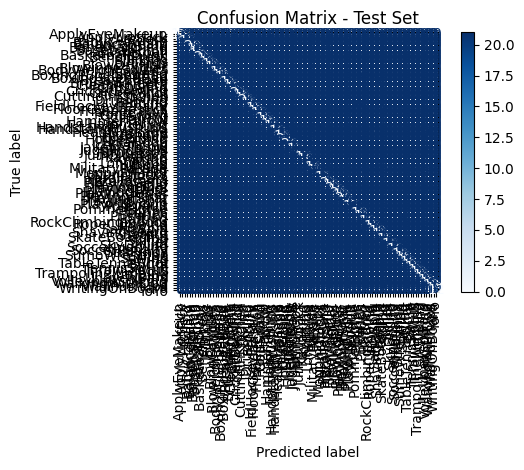

In [2]:
# ============================================================
# TEST EVALUATION: ACCURACY + CONFUSION MATRIX + F1
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. LOAD TEST DATASET
# -----------------------------
TEST_DIR = f"{BASE_PATH}/test"

test_ds = ActionVideoDataset(TEST_DIR, SEQ_LEN)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"Loaded test set with {len(test_ds)} samples")

# -----------------------------
# 2. LOAD BEST SAVED MODEL
# -----------------------------
model, class_names = load_trained_model(
    MODEL_PATH,
    CLASSES_PATH,
    DEVICE
)

# -----------------------------
# 3. RUN TEST INFERENCE
# -----------------------------
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(videos)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# -----------------------------
# 4. METRICS
# -----------------------------
test_acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n📊 TEST ACCURACY: {test_acc:.2f}%\n")

print("📄 Classification Report (Precision / Recall / F1):\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

# -----------------------------
# 5. CONFUSION MATRIX
# -----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(
    cmap=plt.cm.Blues,
    xticks_rotation=90,
    values_format="d"
)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


In [4]:
# ============================================================
# CONTINUE TRAINING WITH EARLY STOPPING (SAFE)
# ============================================================

EXTRA_EPOCHS = 15        # max extra epochs
PATIENCE = 3             # stop if no val improvement for 3 epochs

model = CNN_LSTM(num_classes=len(train_ds.classes))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

if NUM_GPUS > 1:
    model = nn.DataParallel(model)

model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
epochs_no_improve = 0

print("🔄 Resuming training with early stopping...")

for epoch in range(EXTRA_EPOCHS):
    model.train()
    running_loss = 0.0

    for videos, labels in tqdm(train_loader, desc=f"Extra Epoch {epoch+1}/{EXTRA_EPOCHS}"):
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        loss = criterion(model(videos), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ---------------- Validation ----------------
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            preds = model(videos).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    print(f"📊 Epoch {epoch+1}: Loss={avg_loss:.4f}, Val Acc={val_acc:.2f}%")

    # ---------------- Check improvement ----------------
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(
            model.module.state_dict() if isinstance(model, nn.DataParallel)
            else model.state_dict(),
            MODEL_PATH
        )
        print(f"⭐ Improvement! Model saved (Val Acc: {best_acc:.2f}%)")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement ({epochs_no_improve}/{PATIENCE})")

        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping triggered to prevent overfitting.")
            break

print("✅ Continued training finished safely.")


🔄 Resuming training with early stopping...


Extra Epoch 1/15: 100%|██████████| 1257/1257 [07:13<00:00,  2.90it/s]


📊 Epoch 1: Loss=1.1182, Val Acc=79.62%
⭐ Improvement! Model saved (Val Acc: 79.62%)


Extra Epoch 2/15: 100%|██████████| 1257/1257 [07:14<00:00,  2.90it/s]


📊 Epoch 2: Loss=1.0665, Val Acc=78.54%
⚠️ No improvement (1/3)


Extra Epoch 3/15: 100%|██████████| 1257/1257 [07:11<00:00,  2.91it/s]


📊 Epoch 3: Loss=0.9790, Val Acc=81.17%
⭐ Improvement! Model saved (Val Acc: 81.17%)


Extra Epoch 4/15: 100%|██████████| 1257/1257 [07:12<00:00,  2.91it/s]


📊 Epoch 4: Loss=0.9433, Val Acc=82.13%
⭐ Improvement! Model saved (Val Acc: 82.13%)


Extra Epoch 5/15: 100%|██████████| 1257/1257 [07:11<00:00,  2.92it/s]


📊 Epoch 5: Loss=0.8987, Val Acc=83.68%
⭐ Improvement! Model saved (Val Acc: 83.68%)


Extra Epoch 6/15: 100%|██████████| 1257/1257 [07:12<00:00,  2.91it/s]


📊 Epoch 6: Loss=0.8589, Val Acc=83.92%
⭐ Improvement! Model saved (Val Acc: 83.92%)


Extra Epoch 7/15: 100%|██████████| 1257/1257 [07:10<00:00,  2.92it/s]


📊 Epoch 7: Loss=0.8074, Val Acc=84.10%
⭐ Improvement! Model saved (Val Acc: 84.10%)


Extra Epoch 8/15: 100%|██████████| 1257/1257 [07:12<00:00,  2.91it/s]


📊 Epoch 8: Loss=0.7774, Val Acc=85.42%
⭐ Improvement! Model saved (Val Acc: 85.42%)


Extra Epoch 9/15: 100%|██████████| 1257/1257 [07:15<00:00,  2.89it/s]


📊 Epoch 9: Loss=0.7568, Val Acc=85.36%
⚠️ No improvement (1/3)


Extra Epoch 10/15: 100%|██████████| 1257/1257 [07:11<00:00,  2.92it/s]


📊 Epoch 10: Loss=0.7141, Val Acc=87.33%
⭐ Improvement! Model saved (Val Acc: 87.33%)


Extra Epoch 11/15: 100%|██████████| 1257/1257 [07:12<00:00,  2.91it/s]


📊 Epoch 11: Loss=0.6745, Val Acc=86.79%
⚠️ No improvement (1/3)


Extra Epoch 12/15: 100%|██████████| 1257/1257 [07:11<00:00,  2.91it/s]


📊 Epoch 12: Loss=0.6647, Val Acc=86.67%
⚠️ No improvement (2/3)


Extra Epoch 13/15: 100%|██████████| 1257/1257 [07:10<00:00,  2.92it/s]


📊 Epoch 13: Loss=0.6418, Val Acc=85.48%
⚠️ No improvement (3/3)
🛑 Early stopping triggered to prevent overfitting.
✅ Continued training finished safely.


Loaded test set with 1723 samples

📊 TEST ACCURACY: 87.23%

📄 Classification Report (Precision / Recall / F1):

                    precision    recall  f1-score   support

    ApplyEyeMakeup     0.9375    0.7895    0.8571        19
     ApplyLipstick     1.0000    0.9333    0.9655        15
           Archery     0.8889    0.8421    0.8649        19
      BabyCrawling     0.9444    1.0000    0.9714        17
       BalanceBeam     0.8889    0.5714    0.6957        14
      BandMarching     0.9524    1.0000    0.9756        20
     BaseballPitch     1.0000    0.8947    0.9444        19
        Basketball     0.6000    0.6176    0.6087        34
    BasketballDunk     0.3846    0.2941    0.3333        17
        BenchPress     1.0000    0.9500    0.9744        20
            Biking     0.8947    1.0000    0.9444        17
         Billiards     1.0000    1.0000    1.0000        19
       BlowDryHair     0.9231    0.7059    0.8000        17
    BlowingCandles     1.0000    0.8571    0.92

<Figure size 1400x1200 with 0 Axes>

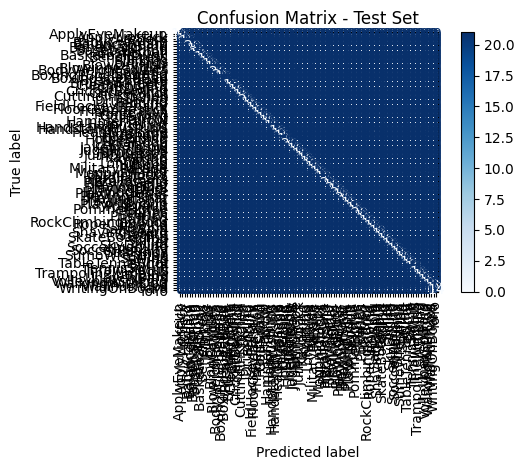

In [5]:
# ============================================================
# TEST EVALUATION: ACCURACY + CONFUSION MATRIX + F1
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. LOAD TEST DATASET
# -----------------------------
TEST_DIR = f"{BASE_PATH}/test"

test_ds = ActionVideoDataset(TEST_DIR, SEQ_LEN)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"Loaded test set with {len(test_ds)} samples")

# -----------------------------
# 2. LOAD BEST SAVED MODEL
# -----------------------------
model, class_names = load_trained_model(
    MODEL_PATH,
    CLASSES_PATH,
    DEVICE
)

# -----------------------------
# 3. RUN TEST INFERENCE
# -----------------------------
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(videos)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# -----------------------------
# 4. METRICS
# -----------------------------
test_acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n📊 TEST ACCURACY: {test_acc:.2f}%\n")

print("📄 Classification Report (Precision / Recall / F1):\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

# -----------------------------
# 5. CONFUSION MATRIX
# -----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(
    cmap=plt.cm.Blues,
    xticks_rotation=90,
    values_format="d"
)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
